In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import random
#from torch_geometric.utils import to_networkx
import networkx as nx

In [3]:
df = pd.read_csv('/home/sknt/Desktop/GNN-MILP_1/Aman_test/Doceree_Complete_DataSet-20230627T054239Z-001/Doceree_Complete_DataSet/Doceree-HCP_Train.csv', encoding= 'ISO-8859-1')

In [4]:
len(df.ID)

113937

In [5]:
df['KEYWORDS'].isnull().sum()

0

In [6]:
df = df.dropna(subset=['IS_HCP'])

In [7]:
test_data = pd.read_csv('/home/sknt/Desktop/GNN-MILP_1/Aman_test/Doceree_Complete_DataSet-20230627T054239Z-001/Doceree_Complete_DataSet/Doceree-HCP_Test.csv')

In [8]:
test_data = test_data[['KEYWORDS']]

In [9]:
test_data = test_data.reset_index(drop=True)

# REMOVING THE UNWANTED COLUMNS: BIDREQUESTIP	USERPLATFORMUID USERZIPCODE

In [10]:
def check_for_null_values(df):
    for column in df.columns:
        print(column,":",df[column].isnull().sum())

In [11]:
def drop_feature(df,column_name):
    if column_name in df.columns:
        df.drop(column_name,axis=True,inplace=True)
    else:
        print(f"{column_name} is not present")

In [12]:
def plot_categoricals(df,column_name):
    grouped = df.groupby(str(column_name))['IS_HCP'].value_counts().unstack().fillna(0)
    print(grouped)
    grouped.plot(kind='bar')
    plt.title(f'Distribution of IS_HCP by {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Count')
    plt.legend(['0', '1'], title='Label')
    plt.show()

In [13]:
unwanted_columns = [ "BIDREQUESTIP", "USERPLATFORMUID","USERZIPCODE"]
df.drop(unwanted_columns,axis=1,inplace=True)

In [14]:
# df.columns

In [15]:
# lt = [
#  'DEVICETYPE',
#  'PLATFORM_ID',
#  'USERCITY',
#  'PLATFORMTYPE',
#  'CHANNELTYPE',
#  'KEYWORDS',
#  'TAXONOMY',
#  'IS_HCP']
# for i in lt:
#     print(i, '->', df[i].value_counts())

IS_HCP          0.0      1.0
DEVICETYPE                  
Desktop     57161.0  21262.0
Mobile      20796.0  11268.0
Tablet       1775.0   1650.0
Unknown        24.0      0.0


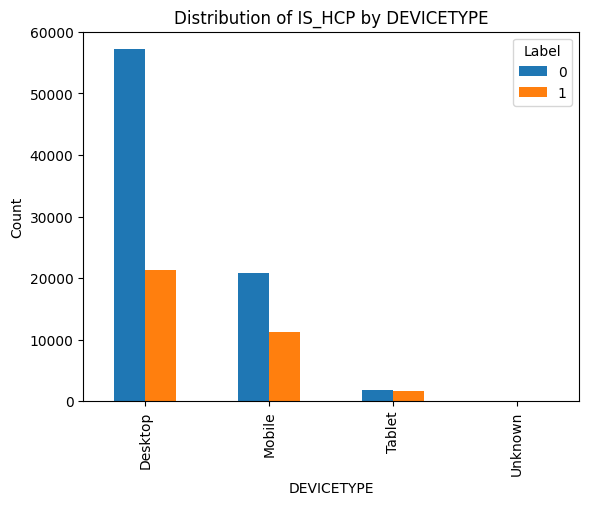

In [16]:
plot_categoricals(df,'DEVICETYPE')

IS_HCP           0.0      1.0
PLATFORM_ID                  
1               31.0      9.0
2            54939.0  24212.0
3                0.0    479.0
4              245.0    500.0
5             3014.0    216.0
6             2032.0    946.0
7            16758.0   4155.0
8               71.0     59.0
9             2453.0   1437.0
10             212.0    825.0
12               0.0    544.0
13               0.0     31.0
14               0.0    725.0
15               0.0     42.0
16               1.0      0.0


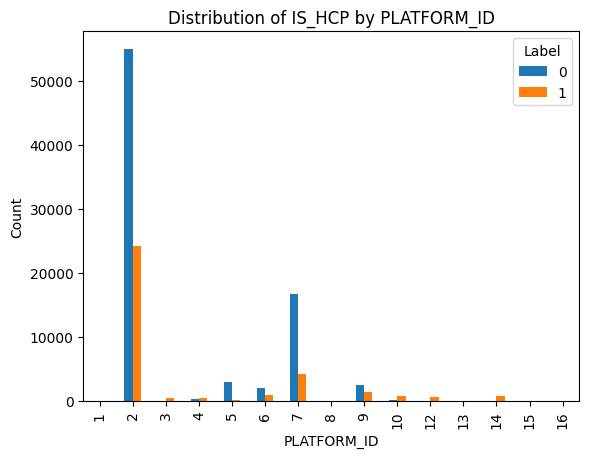

In [17]:
plot_categoricals(df,'PLATFORM_ID')

In [18]:
#plot_categoricals(df,'USERCITY')
#LOT OF VARIATIONS
#NOT MAKING ANY SENSE.
#REMOVE THE FEATURE USERCITY
drop_feature(df,'USERCITY')

df['CHANNELTYPE'].value_counts()
#all the values are "Website". It will not affect the model prediction in any way
#remove the column "CHANNELTYPE"
drop_feature(df,'CHANNELTYPE')


IS_HCP                        0.0      1.0
PLATFORMTYPE                              
Electronic Health Record     31.0      9.0
Medical News Platform         0.0    798.0
Online Learning Portal     2032.0    946.0
Online Medical Journal    77692.0  32427.0
Tele-medicine Platform        1.0      0.0


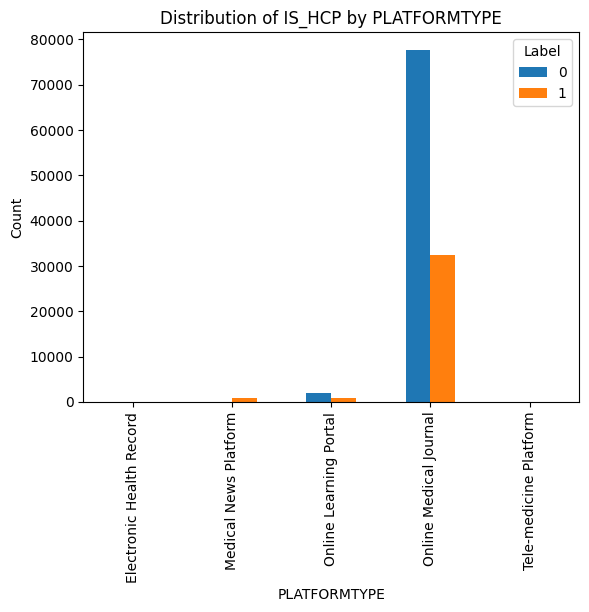

In [19]:
plot_categoricals(df,'PLATFORMTYPE')

# Graph level prediction

In [22]:
dataset = df[['KEYWORDS','IS_HCP']]

In [23]:
dataset.head()

,KEYWORDS,IS_HCP
0,General|Endocrine|False|Medicine|Surgery|Urolo...,0.0
1,Bone Marrow|Radiography|Chronic|Oncology|Psych...,0.0
2,General|Endocrine|False|Medicine|Surgery|Urolo...,0.0
3,Dental|Total|Clinical|Pharmacology|Physicians|...,1.0
4,Critical Care|Emergency Medicine|General Pract...,0.0


In [24]:
dataset = dataset.reset_index(drop=True)

In [25]:
data = []

for i in range(len(dataset)):
    keywords = dataset['KEYWORDS'][i].split('|')
    label = dataset['IS_HCP'][i]

    data.append({
        "keyword" : keywords,
        "label" : label
    })


In [26]:
new_data = []

for i in range(len(test_data)):
    keywords = test_data['KEYWORDS'][i].split('|')
    new_data.append({
        "keyword" : keywords,
    })

In [27]:
len(data), len(new_data)

(113936, 28493)

In [28]:
vocab = set()

for instance in data:
    keyword = instance["keyword"]
    vocab.update(keyword)
    
for instance in new_data:
    keyword = instance["keyword"]
    vocab.update(keyword)
vocab_list = list(vocab)

In [29]:
len(vocab_list)

1620

In [30]:
#dictionary to map keyword to the tensors
import torch



keyword_to_index = {keyword: index for index, keyword in enumerate(vocab_list)}

one_hot_dict = {}

for keyword in vocab_list:
    one_hot_tensor = torch.zeros(len(vocab_list))
    keyword_index = keyword_to_index[keyword]
    one_hot_tensor[keyword_index] = 1
    one_hot_dict[keyword] = one_hot_tensor

# keyword = 'keyword2'
# one_hot_encoded = one_hot_dict[keyword]

# print(one_hot_encoded)

In [31]:
print(len(vocab_list))

1620


In [33]:
import itertools
import tqdm

In [34]:
import itertools

graphs = []

for instance in tqdm.tqdm(data, desc="creating graph"):
    graph = nx.Graph()

    keywords = instance['keyword']
    label = instance['label']

    for i, keyword in enumerate(keywords):
        one_hot_tensor = one_hot_dict[keyword]
        graph.add_node(i, features=one_hot_tensor)

    # Define the edges based on the indices of the keywords in the vocabulary list
    edges = list(itertools.combinations(range(len(keywords)), 2))

    graph.add_edges_from(edges)

    # Store the graph and label in the list
    graphs.append((graph, label))


creating graph: 100%|█████████████████| 113936/113936 [01:21<00:00, 1395.50it/s]


In [35]:
# for i, (graph, label) in enumerate(new_graphs):
#     print("Graph", i+1)
#     print("Nodes:", graph.nodes(data=True))
#     print("Edges:", graph.edges())
#     print("Label:", label)
#     print()

In [36]:
#!pip install torch-geometric

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.data import Data

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = global_add_pool(x, batch)
        x = self.fc(x)
        return x

# Convert the graph dataset to PyG format
pyg_data_list = []
for graph, label in graphs:
    x = torch.stack([graph.nodes[node]['features'] for node in graph.nodes])
    edge_index = torch.tensor([list(edge) for edge in graph.edges]).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)
    pyg_data_list.append(Data(x=x, edge_index=edge_index, y=y))

# Create data loader for batch processing
batch_size = 64
data_loader = DataLoader(pyg_data_list, batch_size=batch_size, shuffle=True)

# Initialize the GNN model
input_dim = len(vocab_list)
hidden_dim = 64
output_dim = 2  # Assuming binary classification (doctor vs. not doctor)
model = GNN(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")


In [40]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch_geometric.data import DataLoader
# from torch_geometric.nn import GATConv, global_add_pool
# from torch_geometric.data import Data

# # Define the GNN model with GAT
# class GNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
#         super(GNN, self).__init__()
#         self.convs = nn.ModuleList()
#         self.convs.append(GATConv(input_dim, hidden_dim, heads=4))
#         for _ in range(num_layers - 1):
#             self.convs.append(GATConv(hidden_dim * 4, hidden_dim, heads=4))
#         self.fc = nn.Linear(hidden_dim * 4, output_dim)

#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch

#         # GAT layers
#         for conv in self.convs:
#             x = conv(x, edge_index)
#             x = torch.relu(x)

#         x = global_add_pool(x, batch)
#         x = self.fc(x)
#         return x

# # Convert the graph dataset to PyG format
# pyg_data_list = []
# for graph, label in graphs:
#     x = torch.stack([graph.nodes[node]['features'] for node in graph.nodes])
#     edge_index = torch.tensor([list(edge) for edge in graph.edges]).t().contiguous()
#     y = torch.tensor([label], dtype=torch.long)
#     pyg_data_list.append(Data(x=x, edge_index=edge_index, y=y))

# # Create data loader for batch processing
# batch_size = 64
# data_loader = DataLoader(pyg_data_list, batch_size=batch_size, shuffle=True)

# # Initialize the GNN model
# input_dim = len(vocab_list)
# hidden_dim = 64
# output_dim = 2  # Assuming binary classification (doctor vs. not doctor)
# num_layers = 3  # Increase the number of layers
# model = GNN(input_dim, hidden_dim, output_dim, num_layers)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# # Training loop
# num_epochs = 4
# model.train()
# for epoch in range(num_epochs):
#     total_loss = 0
#     for data in data_loader:
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, data.y.squeeze())
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     avg_loss = total_loss / len(data_loader)
#     print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")


/home/sknt/miniconda3/envs/tf/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/4, Average Loss: 0.1051
Epoch 2/4, Average Loss: 0.0856
Epoch 3/4, Average Loss: 0.0670
Epoch 4/4, Average Loss: 0.1105


In [ ]:
torch.save(model.state_dict(), 'gnn_model.pt')

In [42]:
# Assuming you have a trained GNN model named 'model'
# and new_data contains the keyword instances for prediction

# Convert new_data to the graph format

new_graphs = []
for instance in tqdm.tqdm(new_data):
    graph = nx.Graph()
    keywords = instance['keyword']
    for i, keyword in enumerate(keywords):
        if keyword in vocab_list:
            one_hot_tensor = one_hot_dict[keyword]
            graph.add_node(i, features=one_hot_tensor)
    edges = list(itertools.combinations(range(len(keywords)), 2))
    graph.add_edges_from(edges)
    new_graphs.append(graph)


100%|███████████████████████████████████| 28493/28493 [00:27<00:00, 1018.36it/s]


In [43]:
# Predict labels for the new data
model.eval()
predictions = []
for graph in tqdm.tqdm(new_graphs, desc="prediction"):
    # Convert the graph to PyG format
    node_indices = list(graph.nodes())
    x = torch.empty(len(node_indices), input_dim)  # Create an empty tensor for node features
    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
    data = Data(x=x, edge_index=edge_index)

    # Assign the node features to the data tensor
    for i, node_index in enumerate(node_indices):
        x[i] = graph.nodes[node_index]['features']

    # Forward pass through the model
    with torch.no_grad():
        output = model(data)

    # Get the predicted label (assumes binary classification)
    predicted_label = torch.argmax(output).item()
    predictions.append(predicted_label)


prediction: 100%|████████████████████████| 28493/28493 [01:25<00:00, 332.93it/s]


In [45]:
test_sub = pd.read_csv('/home/sknt/Desktop/GNN-MILP_1/Aman_test/Doceree_Complete_DataSet-20230627T054239Z-001/Doceree_Complete_DataSet/Doceree-HCP_Test.csv')

In [46]:
test_sub = test_sub[['ID']]

In [47]:
predictions = pd.DataFrame(predictions, columns = ['IS_HCP'])

In [48]:
type(test_sub)

pandas.core.frame.DataFrame

In [49]:
final_submission = pd.concat([test_sub,predictions],axis=1)

In [50]:
final_submission

,ID,IS_HCP
0,115501,0
1,115502,1
2,115503,0
3,115504,0
4,115505,1
...,...,...
28488,143989,0
28489,143990,0
28490,143991,0
28491,143992,0


In [51]:
final_submission.to_csv('final_submission.csv',index=False)